# Identification of Fake News using Ensemble Methods
### Jeffrey Lin Alex Te
#### Santa Clara University
#### COEN281 Term Project 

In [1]:
#libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import re

import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn import tree
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

### Importing Dataset
Here we will inport a dataset taken from: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

In [2]:
# Importing fake news dataset
df_false = pd.read_csv("Fake.csv")
df_false.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [3]:
# Importing true news dataset
df_true = pd.read_csv("True.csv")
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


### Preliminary Data Cleaning

In [4]:
# remove brackets since true dataset has random brackets with the time in it 
# remove entries with empty features
# remove publisher identification (reuters)
# tbd

del df_true['subject']
del df_true['date']
del df_false['subject']
del df_false['date']

for index, row in df_true.iterrows():
    row_text = row['text']
    if ") - " in row_text:
        row_text = row_text.split(") - ")[1]
        
    if bool(re.search('\[\d* \w*\]', row_text)):
        row_text = " ".join(re.split('\[\d* \w*\]', row_text))
        
    row['text'] = row_text

df_true.head()

,title,text
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...


### Combining True/False Datasets

In [5]:
#creating labels for true(1)/false(0)
df_true['category'] = 1
df_false['category'] = 0

In [6]:
#concat datasets into one
df = pd.concat([df_true,df_false]) 

In [7]:
df

,title,text,category
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,1
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,1
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,1
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,1
...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,0
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,0
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,0
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,0


In [8]:
# dataset balance
df.category.value_counts()

0    23481
1    21417
Name: category, dtype: int64

### Splitting Training/Testing Dataset

<AxesSubplot:>

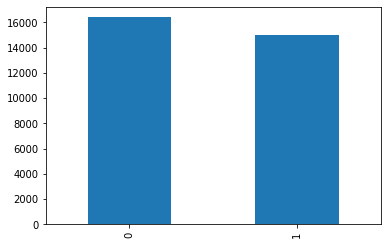

In [9]:
#we are splitting the training and testing dataset here since if we do it later we get a memory error
y = df["category"] 
X = df["text"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
pd.Series(y_train).value_counts().plot.bar()

In [10]:
df_xtrain = pd.DataFrame(X_train)
df_xtrain.head()

,text
8159,Delaying or blocking a planned transition of o...
12191,Hillary Clinton on Thursday decried the spread...
8385,Mylan NV’s move on Thursday to expand discount...
19099,Turkey took the Kurdish television channel Rud...
6690,In a veiled warning to U.S. President-elect Do...


In [11]:
df_xtest = pd.DataFrame(X_test)
df_xtest.head()

,text
2283,Wayde van Niekerk duly qualified for the World...
14819,Ukraine is puzzled by the lack of a U.S. respo...
12196,U.S. President Donald Trump said on Friday tha...
9013,Having stayed close to the Obama family for bo...
16082,President Trump is scheduled to deliver a hist...


### Data Analysis

In [12]:
# point of question
# first check to see if the data is balance (i.e. there are the same number of true articles as there are false)

num_true_articles = len(df_true.index)
num_false_articles = len(df_false.index)

num_articles = num_true_articles if num_true_articles <= num_false_articles else num_false_articles

#num_articles hold the smaller of the two datasets (that way we are comparing the same number of articles)
#time to count the number of words inside each.

true_dataset_num_words_per_article = {}
true_dataset_words = {}
false_dataset_num_words_per_article = {}
false_dataset_words = {}

for index, row in df_true.iterrows():
    if index == num_articles:
        break
    else:
        row_text = row['text']
        string_list = row_text.split()
        true_dataset_num_words_per_article[f"Article{index}"] = len(string_list)
        for word in string_list:
            true_dataset_words[word] = string_list.count(word)

for index, row in df_false.iterrows():
    if index == num_articles:
        break
    else:
        row_text = row['text']
        string_list = row_text.split()
        false_dataset_num_words_per_article[f"Article{index}"] = len(string_list)
        for word in string_list:
            false_dataset_words[word] = string_list.count(word)

print(f"Num words in each of the true dataset: {true_dataset_num_words_per_article}")
print(f"Words in the true dataset (across all {num_articles} articles): {true_dataset_words}")

print(f"Num words in each of the false dataset: {false_dataset_num_words_per_article}")
print(f"Words in the false dataset (across all {num_articles} articles): {false_dataset_words}")

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### NLP Data Processing

In [13]:
# remove puncutation from text
def clean_punc(inputString):
    cleaned = re.sub(r'[?|!|\'|#]', r'', inputString)
    cleaned = re.sub(r'[.|,|)|(|\|/]', r' ', cleaned)
    return cleaned

In [14]:
df_xtrain["text"] = df_xtrain.apply(lambda row: clean_punc(row["text"]), axis=1)
df_xtest["text"] = df_xtest.apply(lambda row: clean_punc(row["text"]), axis=1)

#df["text"] = df.apply(lambda row: clean_punc(row["text"]), axis=1)

In [15]:
# lowercase
def lower_case(inputString):
    return inputString.lower()

In [16]:
df_xtrain["text"] = df_xtrain.apply(lambda row: lower_case(row["text"]), axis=1)
df_xtest["text"] = df_xtest.apply(lambda row: lower_case(row["text"]), axis=1)

#df["text"] = df.apply(lambda row: lower_case(row["text"]), axis=1)

In [17]:
#use this to download wordnet library (one time download)
"""
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('wordnet')
"""

"\nimport nltk\nimport ssl\n\ntry:\n    _create_unverified_https_context = ssl._create_unverified_context\nexcept AttributeError:\n    pass\nelse:\n    ssl._create_default_https_context = _create_unverified_https_context\n\nnltk.download('wordnet')\n"

In [18]:
# lemmatization groups words with the same base meaning together
# i.e. studies studying cries cry -> study studying cry cry
def lemmatization(inputString):
    lemmatizer = WordNetLemmatizer()
    words = []
    for word in inputString.split():
        words.append(lemmatizer.lemmatize(word))
    output = " ".join(words)
    return output

# test
#print(lemmatization("studies studying cries cry"))

In [19]:
# apply lemmatization to text
df_xtrain["text"] = df_xtrain.apply(lambda row: lemmatization(row["text"]), axis=1)
df_xtest["text"] = df_xtest.apply(lambda row: lemmatization(row["text"]), axis=1)

#df["text"] = df.apply(lambda row: lemmatization(row["text"]), axis=1)

In [20]:
# remove stop words that don't provide additional meaning to text
def stopword_removal(inputString):
    sw = stopwords.words('english')
    words = [word for word in inputString.split() if word not in sw]
    output = " ".join(words)
    return output

In [21]:
# apply stopword removal to text
df_xtrain["text"] = df_xtrain.apply(lambda row: stopword_removal(row["text"]), axis=1)
df_xtest["text"] = df_xtest.apply(lambda row: stopword_removal(row["text"]), axis=1)

#df["text"] = df.apply(lambda row: stopword_removal(row["text"]), axis=1)

In [22]:
df_xtrain.head()

,text
8159,delaying blocking planned transition oversight...
12191,hillary clinton thursday decried spread fake n...
8385,mylan nv’s move thursday expand discount progr...
19099,turkey took kurdish television channel rudaw s...
6690,veiled warning u president-elect donald trump ...


In [23]:
df_xtest.head()

,text
2283,wayde van niekerk duly qualified world champio...
14819,ukraine puzzled lack u response request ha mad...
12196,u president donald trump said friday washingto...
9013,stayed close obama family president barack oba...
16082,president trump scheduled deliver historic spe...


### Vectorizing Text

In [24]:
# tfidf vectorizer
# we must .fit() the vectorizer on the training dataset so that when we use .transform()
# the dimension of the resulting df is the same for train and test (it uses the word corpus of training set)
# output_train/test is the sparce matrix, df_xtrain/testvectorized is just for display

tfidf = TfidfVectorizer()
tfidf.fit(df_xtrain["text"]) 
output_train = tfidf.transform(df_xtrain["text"])
df_xtrainvectorized = pd.DataFrame(output_train.toarray(), columns=tfidf.get_feature_names())
df_xtrainvectorized

,00,000,0000,00000017,000063,00007,00042,000938,000a,000after,...,zzg91b1ax8,zzn3bqnfsk,zzqvyk8xif,zztaine,zzucqevt3m,zzuml4hkoc,zzzzaaaacccchhh,zzzzzzzz,zzzzzzzzzzzzz,émigré
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31423,0.0,0.013943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31424,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31425,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31426,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
output_test = tfidf.transform(df_xtest["text"])
df_xtest_vectorized = pd.DataFrame(output_test.toarray(), columns=tfidf.get_feature_names())
df_xtest_vectorized

,00,000,0000,00000017,000063,00007,00042,000938,000a,000after,...,zzg91b1ax8,zzn3bqnfsk,zzqvyk8xif,zztaine,zzucqevt3m,zzuml4hkoc,zzzzaaaacccchhh,zzzzzzzz,zzzzzzzzzzzzz,émigré
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.086039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13465,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13466,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13467,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13468,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
#note: there is a lot of garbage values

tfidf.get_feature_names()

['00',
 '000',
 '0000',
 '00000017',
 '000063',
 '00007',
 '00042',
 '000938',
 '000a',
 '000after',
 '000although',
 '000american',
 '000california',
 '000cases',
 '000cylvia',
 '000dillon000',
 '000ecuador',
 '000florida',
 '000georgia',
 '000have',
 '000illegal',
 '000illinois',
 '000in',
 '000jose',
 '000kyrgyzstan',
 '000maga',
 '000michigan',
 '000new',
 '000oman',
 '000s',
 '000saudi',
 '000some',
 '000south',
 '000th',
 '000that',
 '000the',
 '001',
 '00106',
 '0011',
 '00155',
 '0018',
 '00193',
 '001romney',
 '001st',
 '002',
 '0020',
 '002singapore',
 '003',
 '004',
 '00458',
 '004saint',
 '005',
 '0050',
 '005380',
 '005930',
 '006',
 '00654',
 '00684',
 '007',
 '0075',
 '008',
 '00867',
 '009',
 '00am',
 '00c6j7capuhttps',
 '00pm',
 '00pme',
 '01',
 '010',
 '0100',
 '01000110',
 '01010101',
 '011',
 '012',
 '01233',
 '013',
 '0130',
 '014',
 '01494',
 '015',
 '01517',
 '015760',
 '016',
 '017',
 '019',
 '01am',
 '01vcq3uzgx',
 '01wiw6prwy',
 '02',
 '020',
 '0200',
 '02046'

### Decision Tree

In [27]:
# Decision Tree Model

dt = tree.DecisionTreeClassifier()
dt.fit(output_train, y_train)

DecisionTreeClassifier()

In [28]:
resultDT = dt.predict(output_test)
resultDT = resultDT.round(0)

In [29]:
#Displaying the confusion matrix
print('Confusion Matrix - Decision Tree')
print(pd.crosstab(y_test, resultDT, rownames = ['True'], colnames = ['Predicted'], margins = True))

Confusion Matrix - Decision Tree
Predicted     0     1    All
True                        
0          6825   252   7077
1           388  6005   6393
All        7213  6257  13470


In [30]:
print('F1 score - Decision Tree:')
print(f1_score(y_test, resultDT, average='macro'))

F1 score - Decision Tree:
0.9523102752968575


### Random Forest

In [31]:
# Random Forest Model

rf_regr = RandomForestRegressor(n_estimators=20, random_state=0)
rf_regr.fit(output_train, y_train)

RandomForestRegressor(n_estimators=20, random_state=0)

In [32]:
resultRF = rf_regr.predict(output_test)
resultRF = resultRF.round(0)

In [33]:
#Displaying the confusion matrix
print('Confusion Matrix - Random Forest')
print(pd.crosstab(y_test, resultRF, rownames = ['True'], colnames = ['Predicted'], margins = True))

Confusion Matrix - Random Forest
Predicted   0.0   1.0    All
True                        
0          6937   140   7077
1           246  6147   6393
All        7183  6287  13470


In [34]:
print('F1 score - Random Forest:')
print(f1_score(y_test, resultRF, average='macro'))

F1 score - Random Forest:
0.9712448179593931


### XGBoost 

In [35]:
#XGBoost Model

xgb = XGBClassifier(n_estimators=20, random_state=0)
xgb.fit(output_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=20, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [36]:
resultXGB = xgb.predict(output_test)
resultXGB = resultXGB.round(0)

In [37]:
#Displaying the confusion matrix
print('Confusion Matrix - XGBClassifier')
print(pd.crosstab(y_test, resultXGB, rownames = ['True'], colnames = ['Predicted'], margins = True))

Confusion Matrix - XGBClassifier
Predicted     0     1    All
True                        
0          6893   184   7077
1           202  6191   6393
All        7095  6375  13470


In [38]:
print('F1 score - XGBClassifier:')
print(f1_score(y_test, resultXGB, average='macro'))

F1 score - XGBClassifier:
0.9712656827292618


### Stacking Classifier (Note: Extremely long train time, do not run)

In [ ]:
#Stacking classifier with naive bayes and decision trees as base learners then log reg as final estimator.

estimators = [
    ('nb', MultinomialNB()),
    ('dt', tree.DecisionTreeClassifier())
]
    
stacking = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking.fit(output_train.toarray(), y_train)

In [ ]:
resultStacking = stacking.predict(output_test)
resultStacking = resultStacking.round(0)

In [ ]:
#Displaying the confusion matrix
print('Confusion Matrix - Stacking Classifier')
print(pd.crosstab(y_test, resultStacking, rownames = ['True'], colnames = ['Predicted'], margins = True))

In [ ]:
print('F1 score - Stacking Classifier:')
print(f1_score(y_test, resultStacking, average='macro'))